# Sparkify Churn  





## Table of Contents
* [Introduction](#int)
* [Load and Clean Dataset](#load)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#eng)
* [Modelling](#model)
* [Conclusions](#con)

## Introduction
<a class="anchor" id="int"></a>

In this project, I'll use Spark to process a Spotify-like music app dataset. The goal is to create predictive features for identifying churn, which means customers cancelling their service. By detecting potential churners in advance, the business can provide incentives to retain them and potentially save revenue. This workspace has a 128MB subset of the full 12GB dataset.

First let's import the necessary libraries.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We can now create a Spark Session.

In [4]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [5]:
# Retrieve Spark configuration
spark_conf = spark.sparkContext.getConf().getAll()
spark_conf

[('spark.sql.warehouse.dir',
  'file:/Users/althorman/Projects/DSND/Sparkfiy/spark-warehouse'),
 ('spark.app.submitTime', '1695372040257'),
 ('spark.driver.host', 'macbook-pro-2'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1695372040509'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --

## Load and Clean Dataset
<a class="anchor" id="load"></a>
The dataset, named `mini_sparkify_event_data.json`, is initially loaded. Subsequently, a check is performed to identify and address any issues related to invalid or missing data. This involves examining records for instances where `userId` or `sessionId` is absent and taking appropriate action.

In [6]:
# Load the dataset
df = spark.read.json("mini_sparkify_event_data.json")


In [7]:
# Print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Generate summary statistics for the DataFrame
df.describe().show()

23/09/22 11:44:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

The current datatypes are appropriate for this stage, and no adjustments are needed.

In [9]:
# Display the first two rows of the DataFrame
df.take(2)


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [10]:
# Get the count of the dataset before any cleaning (should be 286500)
df.count()

286500

The dataset, prior to any cleaning operations, contains 286,500 rows.

### Drop Rows with Missing Values

First we will drop any rows with missing values in the userid or sessionid.

In [11]:
# Drop rows with missing values in userId or sessionId
df = df.dropna(how='any', subset=["userId", "sessionId"])

In [12]:
# Get the count of the dataset before any cleaning (should be 286500)
df.count()

286500

As we can see from the above, the row count is still the same at 286500. Let's take a closer look.

In [13]:
# Drop duplicate userIds
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



From the above output, it's evident that some entries have empty strings as userIds. We'll address this issue after conducting a thorough investigation of the sessionId.

In [14]:
# Display unique sessionIds in ascending order
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



The sessionId appears to be in order. However, as observed earlier, there are entries with empty strings for the userId. These entries should now be removed.

In [15]:
# Remove rows with empty string userId
df = df.filter(df["userId"] != "")

In [16]:
# Get the count of the dataset before any cleaning (should be 286500)
df.count()

278154

In this cleaning step, we have removed 8346 rows, resulting in a dataset size of 278154 rows.

In [17]:
# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


## Exploratory Data Analysis

### Define Churn

A new column `Churn` will be created to serve as the label for our model. Churn will be defined using `Cancellation Confirmation` events, which occur for both paid and free users. A value of 1 will be assigned where a user has churned, and 0 where they have not.

### Explore Data

The exploratory data analysis will involve observing the behavior of users who stayed versus users who churned. This will begin by examining aggregates for these two groups of users, including how frequently they performed specific actions over a certain time period or number of songs played.


### Identify users who have churned

First, we will identify the users who have churned using the `Cancellation Confirmation` event under the `page` column.

In [18]:
# Check the unique pages, including "Cancellation Confirmation"
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



From the above output, it's evident that the "Cancellation Confirmation" page is where a user is directed after confirming their decision to cancel the service. This page serves as our identifier for churn.

In [19]:
# Count the number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

From the above cell we can see that there are 52 users in our dataset that have churned. We can take a closer look at the userids that churned.

In [20]:
# Show the userIds and page for users who confirmed cancellation
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



We will now create the flag for churned users who will be assigned a 1 if churned and a 0 where they have not churned. This flag will be added to the dataset as a column named "churn".

In [21]:
# Define a user-defined function to flag Cancellation Confirmation events
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [22]:
# Creating Churn Column
df = df.withColumn("churn", churn_event("page"))

In [23]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

From the above example, it is evident that the churn column has been successfully incorporated into the dataframe, and a value of 0 has been assigned for this specific userId. We can now proceed to sort our records for a given userId in reverse time order and sum up the values in the churn column.

In [24]:
# Sort records for a user in reverse time order to facilitate summing up values in the churn column
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [25]:
# Create Churn Column
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [26]:
# Group by churn to get counts
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [27]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### EDA for Users that Stayed vs Users that Churned

Now we can examine behaviour of those who churned vs those who did not churn. First we will visualise those who churned vs those who stayed.

In [28]:
# Convert to Pandas for visualization
df_churn = df_churn.toPandas()

Text(0.5, 1.0, 'Number of Users That Churned')

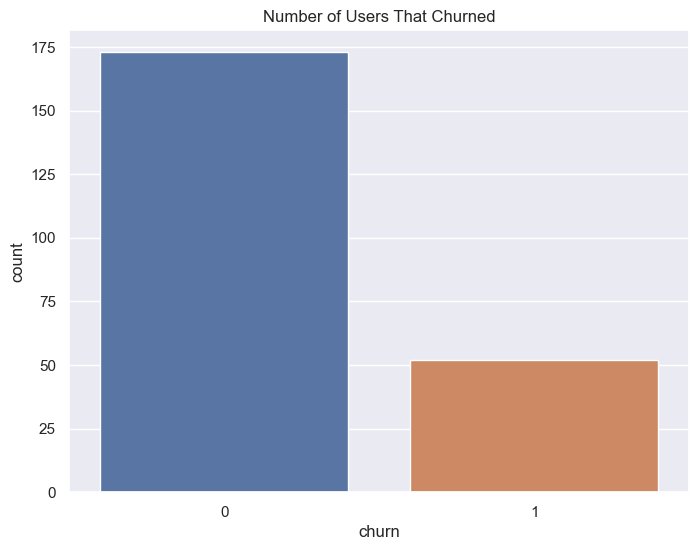

In [29]:
# Plot the number of users that churned
plt.figure(figsize=[8, 6])
ax = sns.barplot(data=df_churn, x='churn', y='count')
plt.title("Number of Users That Churned")

In [30]:
# Calculate the churn rate
churned = 52
retained = 173
churn_rate = (churned / (churned + retained)) * 100
churn_rate


23.11111111111111

From the above, we can observe that out of the total users, 173 chose to stay while 52 decided to churn. Consequently, this indicates that 23% of our users churned. It's crucial to acknowledge that this represents an imbalance in our dataset, which should be taken into consideration in further analysis.

### Length of time: Users that Churned vs. Users that Stayed

We can now look at the length distribution for customers who stayed and those which churned. 

In [31]:
# Get the customers who churned
df_churned = df.filter(df.churn == 1)

In [32]:
# Convert to Pandas DataFrame
df_pd = df_churned.toPandas()

In [33]:
# Drop null values from the 'length' column
df_pd['length'].dropna(inplace=True)

Text(0, 0.5, 'Frequency')

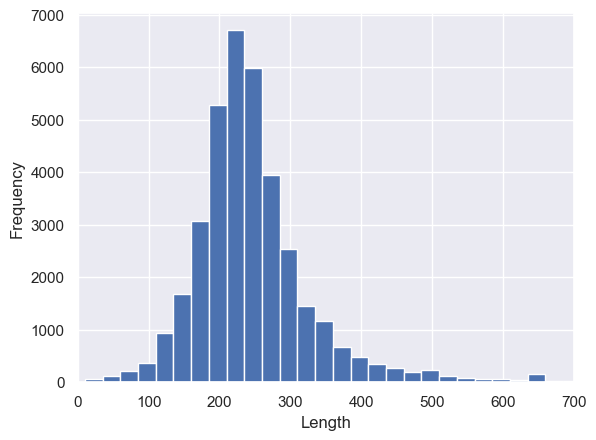

In [34]:
# Plot the distribution of 'length'
bin_edges = np.arange(10, df_pd['length'].max() + 25, 25)
plt.hist(data=df_pd, x='length', bins=bin_edges)
plt.xlim(0, 700)
plt.xlabel('Length')
plt.ylabel('Frequency')


Now we can do the same process for customers who didn't churn.

In [35]:
# Get the users who stayed
df_stayed = df.filter(df.churn == 0)

In [36]:
# Convert to Pandas DataFrame
df_pd = df_stayed.toPandas()

In [37]:
# Drop null values from the 'length' column
df_pd['length'].dropna(inplace=True)

Text(0, 0.5, 'Frequency')

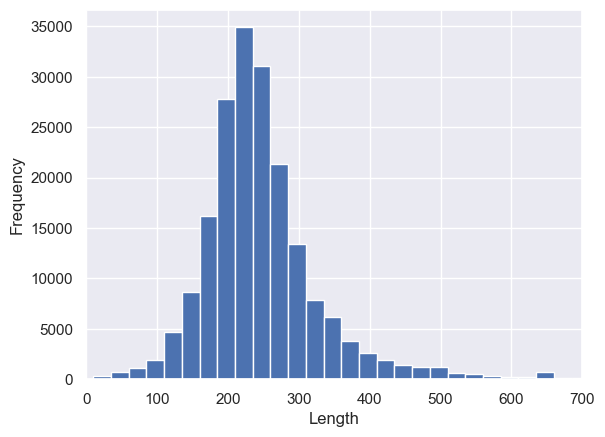

In [38]:
# Plot the distribution of 'length' for users who stayed
bin_edges = np.arange(10, df_pd['length'].max() + 25, 25)
plt.hist(data=df_pd, x='length', bins=bin_edges)
plt.xlim(0, 700)
plt.xlabel('Length')
plt.ylabel('Frequency')

From the above plots, it's evident that the length distribution is very similar for users who churned and those who stayed. This similarity suggests that length alone may not be very useful for predicting customer churn. Let's explore a categorical feature instead, such as gender.

###  Gender - Users who Churned vs Users who Stayed

Now we can examine if gender had an effect on users that churned vs. those that stayed.

In [39]:
# Create a DataFrame for gender grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [40]:
# Show the gender DataFrame
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [41]:
# Convert to Pandas DataFrame for visualization
df_gender = df_gender.toPandas()

In [42]:
# Order the DataFrame for visualization
df_gender = df_gender.sort_values('count', ascending=False)

Text(0.5, 1.0, 'Number of Users That Churned by Gender')

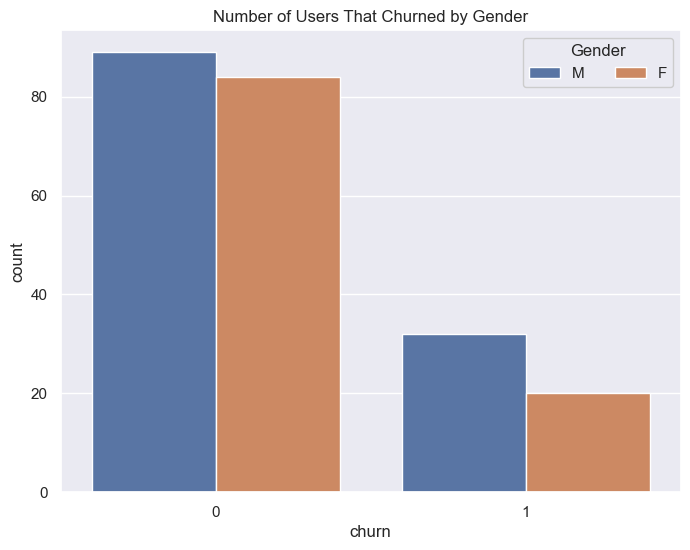

In [43]:
# Seaborn barplot for churn by gender
plt.figure(figsize=[8, 6])
ax = sns.barplot(data=df_gender, x='churn', y='count', hue='gender')
ax.legend(loc=1, ncol=2, framealpha=1, title='Gender')
plt.title("Number of Users That Churned by Gender")

In [44]:
# male churn rate

male_churned = 32
male_retained = 89
male_churn_rate = (male_churned / (male_churned + male_retained)) * 100
male_churn_rate


26.446280991735538

In [45]:
# female churn rate
female_churned = 20
female_retained = 84
female_churn_rate = (female_churned / (female_churned + female_retained)) * 100
female_churn_rate

19.230769230769234

From the above chart, we can see that more male users churned(rate of 0.264) compared to female users (rate of 0.192).

### Users who Churned vs Stayed by Level

Next we can examine if level has an effect on whether a user will churn or not. By level here we mean if the user paid for the app or if they used it for free with ads.

In [46]:
# Create a DataFrame for user level grouped by churn and level
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level', 'churn').count()

In [47]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [48]:
# Convert to Pandas DataFrame for visualization
df_level = df_level.toPandas()

Text(0.5, 1.0, 'Number of Users That Churned by Level')

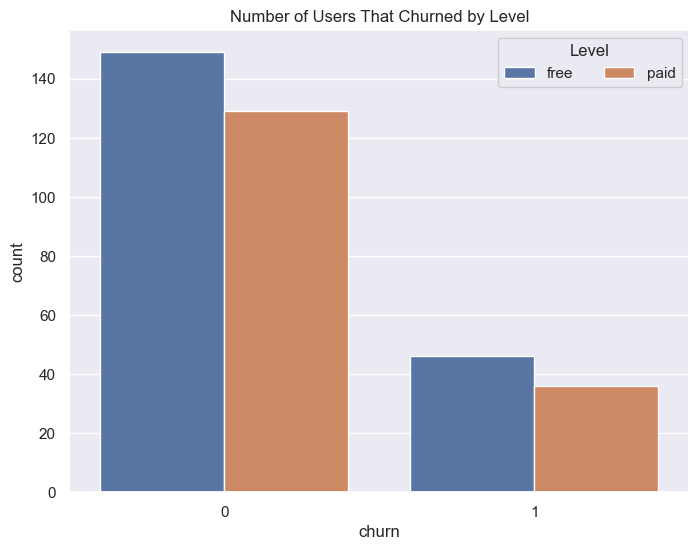

In [49]:
# Seaborn barplot for churn by user level
plt.figure(figsize=[8, 6])
ax = sns.barplot(data=df_level, x='churn', y='count', hue='level')
ax.legend(loc=1, ncol=2, framealpha=1, title='Level')
plt.title("Number of Users That Churned by Level")

In [50]:
# free churn rate
free_churned = 46
free_retained = 149
free_churn_rate = (free_churned / (free_churned + free_retained)) * 100
free_churn_rate

23.589743589743588

In [51]:
# paid churn rate
paid_churned = 36
paid_retained = 129
paid_churn_rate = (paid_churned / (paid_churned + paid_retained)) * 100
paid_churn_rate


21.818181818181817

We can see from the above chart that more users who used the service for free were slightly more likely to churn (rate of 0.236) compared to those who paid for the app (0.218).

### Pages Visited by Those that Churned vs. Those That Stayed

Next we can examine if there were different pages visited by users that churned compared to those that remained.

In [52]:
# Create a DataFrame for page interactions grouped by churn and page
df_page = df.select(['userId', 'churn', 'page']).groupBy('page', 'churn').count()

In [53]:
df_page.show(40)

+--------------------+-----+------+
|                page|churn| count|
+--------------------+-----+------+
|            Settings|    0|  1244|
|         Thumbs Down|    1|   496|
|           Thumbs Up|    1|  1859|
|     Add to Playlist|    1|  1038|
|               Error|    1|    32|
|               About|    1|    56|
|         Thumbs Down|    0|  2050|
|         Roll Advert|    1|   967|
|                Home|    0|  8410|
|Cancellation Conf...|    1|    52|
|               Error|    0|   220|
|              Cancel|    1|    52|
|            Settings|    1|   270|
|          Add Friend|    1|   636|
|             Upgrade|    0|   387|
|           Downgrade|    1|   337|
|              Logout|    1|   553|
|    Submit Downgrade|    1|     9|
|       Save Settings|    0|   252|
|           Thumbs Up|    0| 10692|
|           Downgrade|    0|  1718|
|      Submit Upgrade|    0|   127|
|         Roll Advert|    0|  2966|
|    Submit Downgrade|    0|    54|
|              Logout|    0|

In [54]:
# Convert to Pandas DataFrame for visualization
df_page = df_page.toPandas()

In [55]:
# Create counts for those who churned and those who stayed
churn_count = df_page[df_page['churn'] == 1].sum()
stay_count = df_page[df_page['churn'] == 0].sum()

Now that we have a count of the number of customers who churned and those that stayed we can calculate the rate and create this as a column on our dataFrame.

In [56]:
# Calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count'] / stay_count['count'], 
    np.where(df_page['churn'] == 1, df_page['count'] / churn_count['count'], df_page['count'] / churn_count['count'])
)

In [57]:
df_page.head(40)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


Text(0.5, 1.0, 'Rate of Pages Navigated to by Users that Churned vs. Users that Stayed')

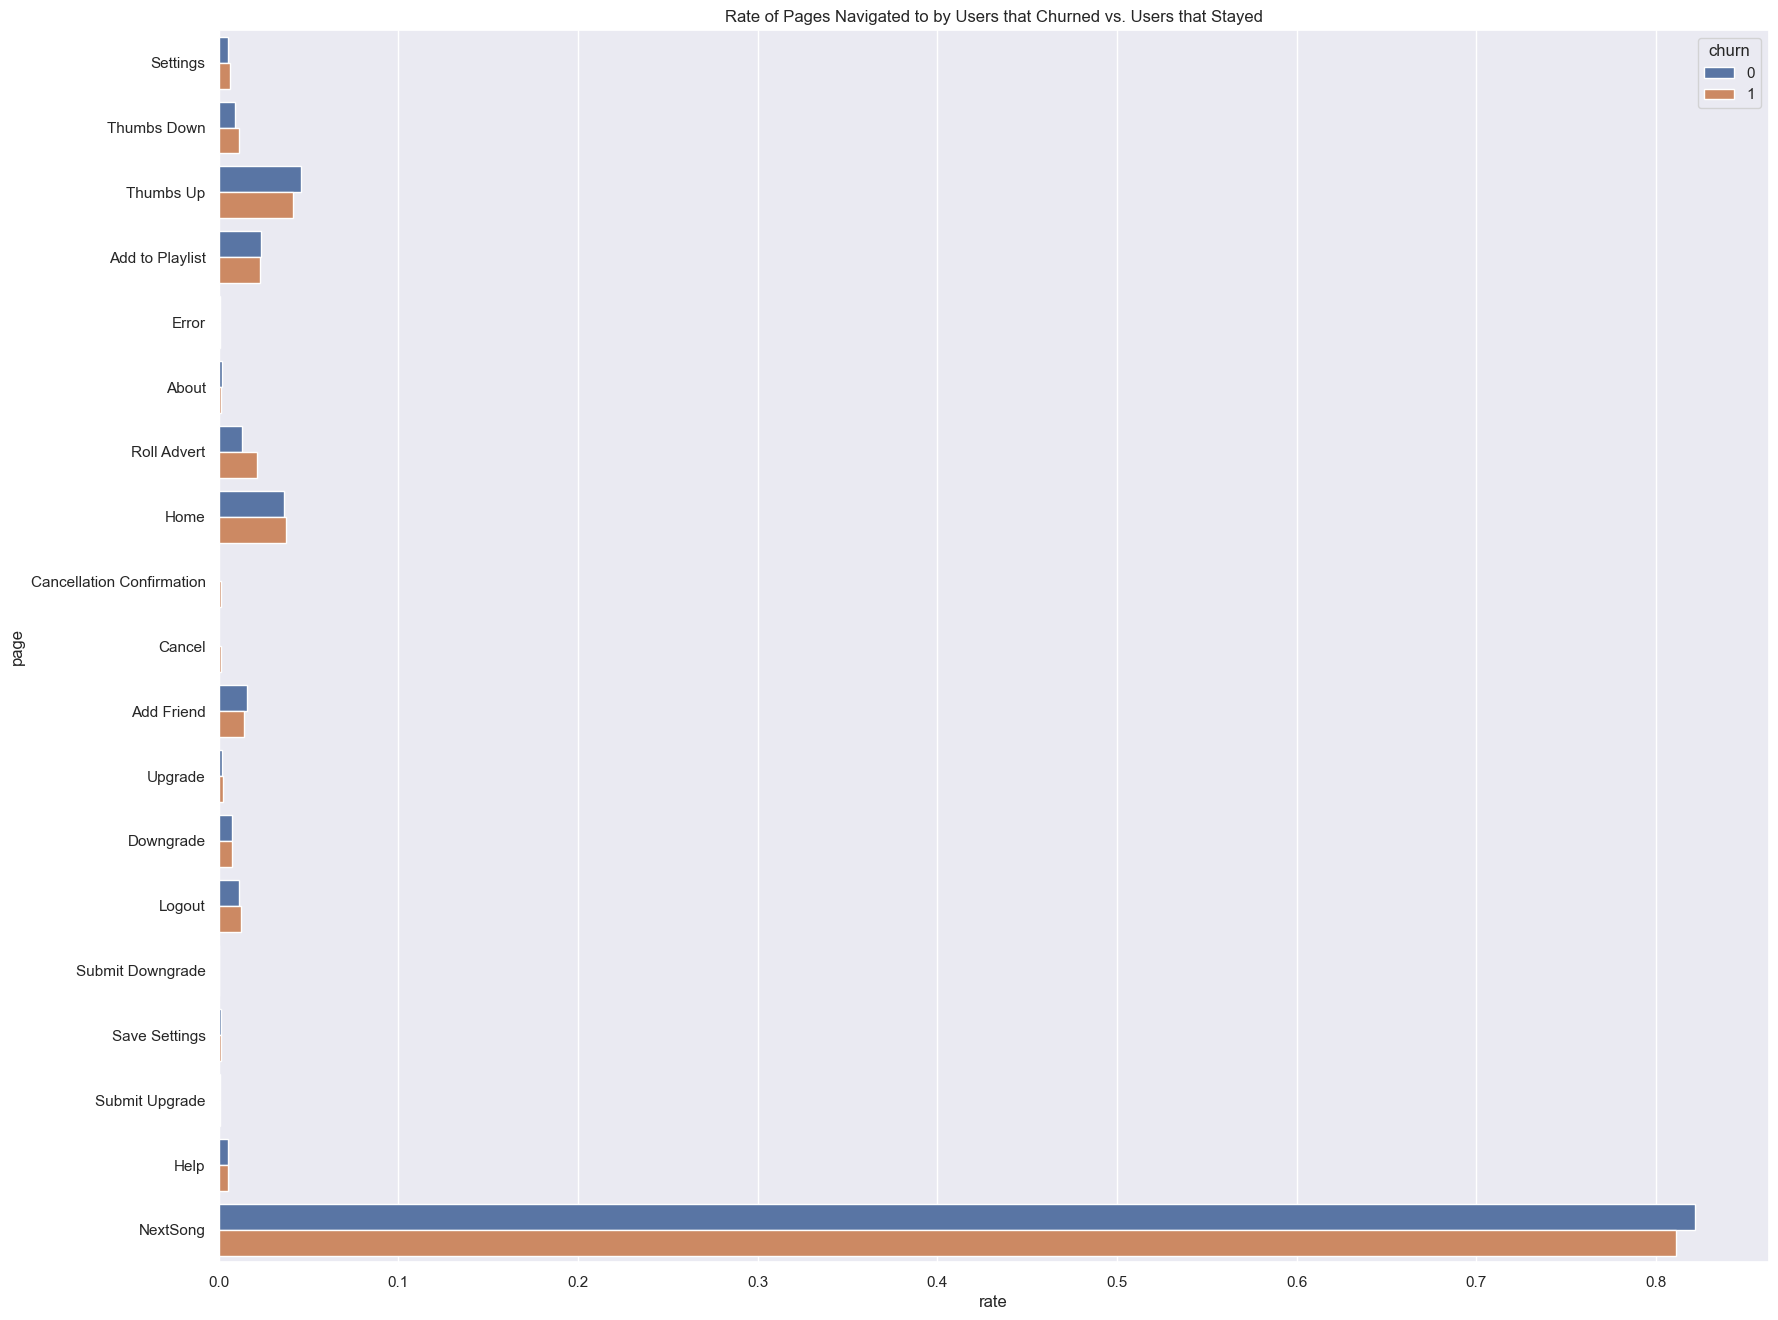

In [58]:
# Plot the pages by churn
plt.figure(figsize=[20,16])
sns.barplot(data=df_page, x='rate', y='page', hue='churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed')

From the above chart, we observe that the most popular action for both users who stayed and those who churned was to skip to the next song. Additionally, churned users were more likely to interact with advertisements and give thumbs down to songs. On the other hand, users who were more likely to stay tended to perform more thumbs up actions, add friends, and add songs to their playlists.

### Calculating Songs per Hour

We can now turn our attention to calculating the number of songs listened to by churn and non churn users per hour. 

In [59]:
# Define a user-defined function to extract the hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [60]:
# Create an 'hour' column
df = df.withColumn("hour", get_hour(df.ts))

In [61]:
df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='21')

First we can look at those who didn't churn.

In [62]:
# Create a DataFrame with users who didn't churn and count when user goes to the next song page
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [63]:
songs_in_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 8853|
|   1| 8526|
|   2| 8085|
|   3| 7527|
|   4| 7035|
|   5| 7014|
|   6| 7063|
|   7| 6914|
|   8| 6960|
|   9| 6836|
|  10| 6873|
|  11| 7023|
|  12| 7268|
|  13| 7502|
|  14| 7440|
|  15| 7918|
|  16| 8073|
|  17| 8792|
|  18| 9462|
|  19| 9721|
|  20| 9464|
|  21| 9146|
|  22| 9112|
|  23| 9107|
+----+-----+



In [64]:
# Convert to Pandas DataFrame and then to numeric
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd['hour'] = pd.to_numeric(songs_in_hour_stay_pd['hour'])

In [65]:
songs_in_hour_stay_pd

,hour,count
0,0,8853
1,1,8526
2,2,8085
3,3,7527
4,4,7035
5,5,7014
6,6,7063
7,7,6914
8,8,6960
9,9,6836


Text(0.5, 1.0, 'Number of Songs Played per Hour (Non Churn Users)')

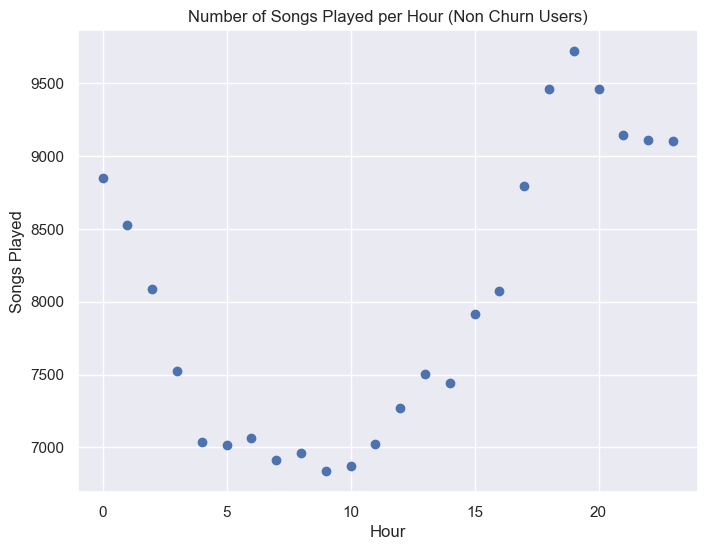

In [66]:
# Plot the distribution of songs played per hour for non-churn users
plt.figure(figsize=[8, 6])
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs Played")
plt.title("Number of Songs Played per Hour (Non Churn Users)")

From above we can see that there is a peak of songs played between 3pm and 8pm. Next we will examine users who churned by using the same process.

In [67]:
# Create a DataFrame with customers who churned and count when user goes to the next song page
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [68]:
songs_in_hour_churned.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1605|
|   1| 1596|
|   2| 1545|
|   3| 1535|
|   4| 1353|
|   5| 1322|
|   6| 1292|
|   7| 1233|
|   8| 1218|
|   9| 1218|
|  10| 1218|
|  11| 1230|
|  12| 1230|
|  13| 1380|
|  14| 1390|
|  15| 1408|
|  16| 1571|
|  17| 1702|
|  18| 1892|
|  19| 1915|
+----+-----+
only showing top 20 rows



In [69]:
# Convert to Pandas DataFrame and then to numeric
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned['hour'] = pd.to_numeric(songs_in_hour_churned['hour'])

Text(0.5, 1.0, 'Number of Songs Played per Hour (Users who Churned)')

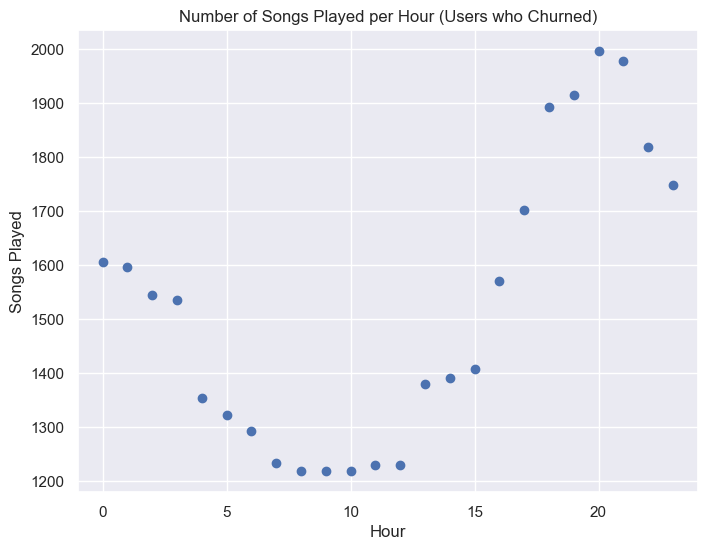

In [70]:
# Plot the distribution of songs played per hour for churned users
plt.figure(figsize=[8, 6])
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs Played")
plt.title("Number of Songs Played per Hour (Users who Churned)")

We can see users that churned had a similar distribution, however they listened to fewer songs per hour than users that stayed.

### Songs Per Session for Users who Churned vs. Those who Stayed

We can plot this in a simple way which will allow us to compare those who churned and those who stayed in a bar chart by getting the averages for both groups.

In [71]:
# Create a DataFrame for song interactions grouped by sessionId and churn
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId', 'churn').count()

In [72]:
# Get the average count of songs played, grouped by churn
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [73]:
# Get the average count of songs played, grouped by churn
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

In [74]:
# convert this to pandas df
df_songs = df_songs.toPandas()

Text(0, 0.5, 'Average Number of Songs Played Per Session')

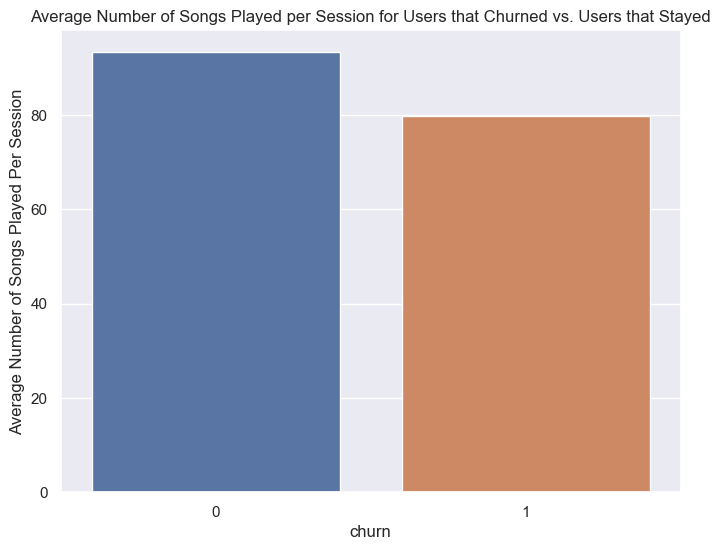

In [75]:
# Plot the average number of songs played per session for users who churned vs. users who stayed
plt.figure(figsize=[8, 6])
ax = sns.barplot(data=df_songs, x='churn', y='avg(count)')
plt.title("Average Number of Songs Played per Session for Users that Churned vs. Users that Stayed")
plt.ylabel("Average Number of Songs Played Per Session")

From the chart we can see that those churned from Sparkify actually listening to fewer songs on average per session.

### Number of Unique Artists Listened to

We can create a similar chart for the number of artists that users listened to.

In [76]:
# Create a DataFrame for artist interactions grouped by userId and churn
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [77]:
# get averages
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [78]:
# Convert to Pandas DataFrame
df_artists = df_artists.toPandas()

We can plot this as a boxplot to see the max and medians for both groups. 

Text(0.5, 1.0, 'Number of Artists Listened to on Sparkify')

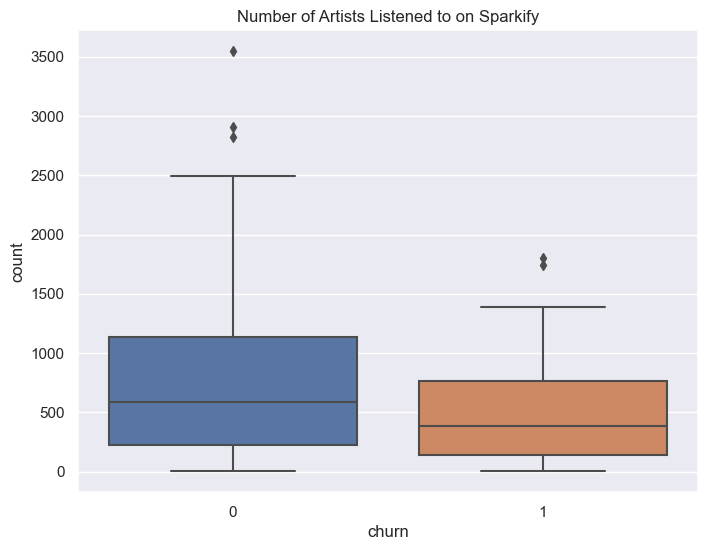

In [79]:
# Plot a boxplot for the number of artists listened to on Sparkify, grouped by churn
plt.figure(figsize=[8, 6])
ax = sns.boxplot(data=df_artists, x='churn', y='count')
plt.title("Number of Artists Listened to on Sparkify")

From the above we can see that those who didn't churn listened to a larger number of different artists compared to those who churned.

### Location

We can now examine if location had an effect on churn.

In [80]:
# Get counts of users by location
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder...| 3764|
|           Selma, AL| 2027|
|Bridgeport-Stamfo...|  893|
|           Price, UT| 1102|
|Providence-Warwic...|  927|
+--------------------+-----+
only showing top 20 rows



Let's just extract the state from the location by taking the last two characters in the location string.

In [81]:
# Define a user-defined function to get the last two characters of a string
get_state = udf(lambda x: x[-2:])

In [82]:
# Create a new column 'state' by extracting the last two characters from the 'location' column
df_state = df.withColumn("state", get_state(df.location))

In [83]:
# Check if the 'state' column was created successfully
df_state.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='21', state='CT'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='21', stat

In [84]:
# Create a DataFrame for state interactions grouped by state and churn
df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

In [85]:
# convert to Pandas DataFrame
df_state_pd = df_state.toPandas()

Text(0.5, 1.0, 'Count of Users that Churned vs. Users that Stayed by US State')

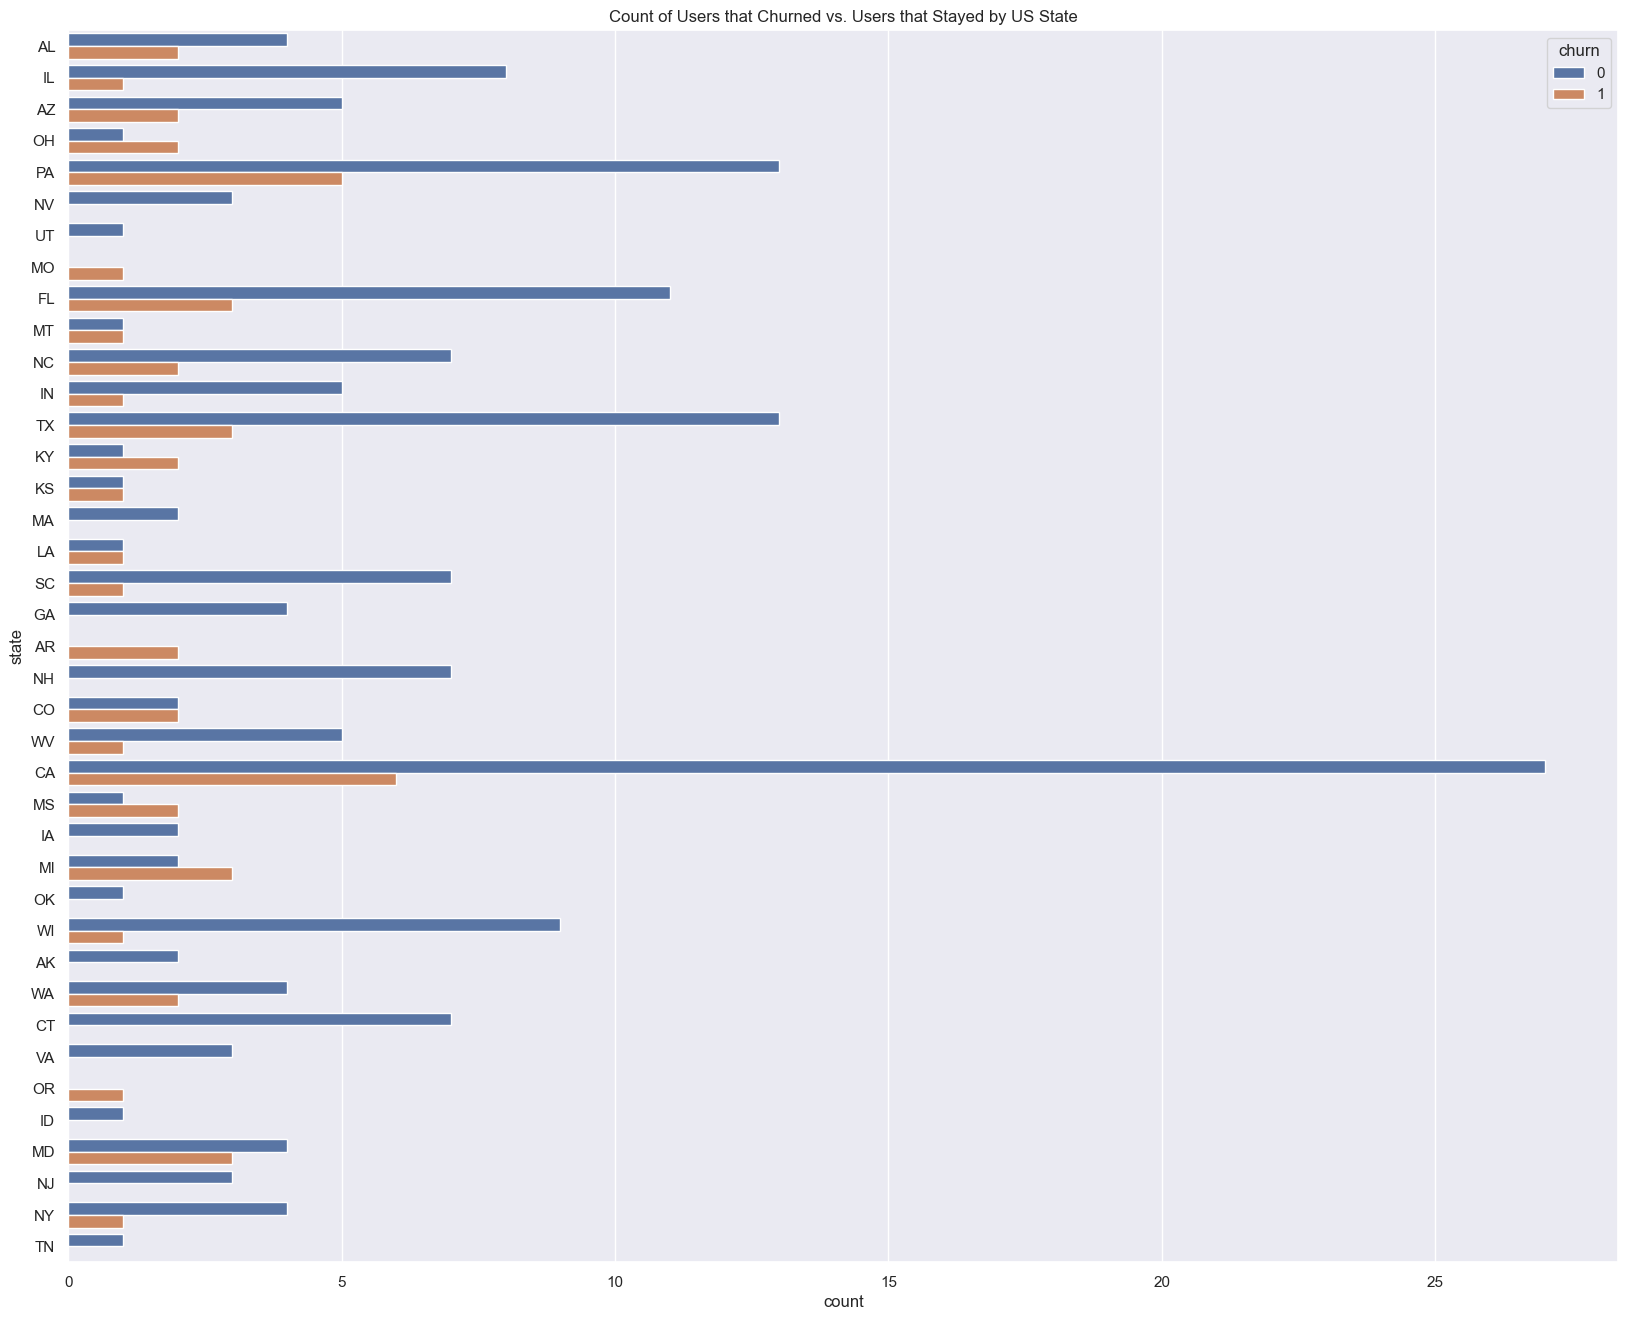

In [86]:
# Plot the count of users that churned vs. users that stayed by US State
plt.figure(figsize=[20, 16])
sns.barplot(data=df_state_pd, x='count', y='state', hue='churn')
plt.title('Count of Users that Churned vs. Users that Stayed by US State')

Most users were based in CA. More users in MI, KY, and OH states churned than stayed. This may be difficult to engineer a useful feature for when it comes to modelling. Let's leave this for now and move onto another column from our dataset; operating systems and browsers.

### UserAgent: Operating System and Browsers

Now we can extract the Operating System a user is on to understand if this has an effect on churn.

In [87]:
# Create a DataFrame for user operating system interactions, removing duplicates based on userId
df_opsys = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])

In [88]:
df_opsys.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|   100|Mozilla/5.0 (Wind...|    0|
|100005|"Mozilla/5.0 (Mac...|    1|
|100006|"Mozilla/5.0 (Win...|    1|
|100007|"Mozilla/5.0 (Win...|    1|
|100008|Mozilla/5.0 (Maci...|    0|
|100010|"Mozilla/5.0 (iPh...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|100021|"Mozilla/5.0 (Mac...|    1|
|100022|Mozilla/5.0 (Maci...|    1|
|100025|"Mozilla/5.0 (Mac...|    1|
|   101|Mozilla/5.0 (Wind...|    1|
|   107|Mozilla/5.0 (Wind...|    0|
|    11|Mozilla/5.0 (Wind...|    0|
|   110|"Mozilla/5.0 (Mac...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
|   113|"Mozilla/5.0 (Mac...|    0|
|   118|"Mozilla/5.0 (Win...|    0|
|   120|"Mozilla/5.0 (Mac...|    0|
|   124|"Mozilla/5.0 (Mac...|    0|
|   125|"Mozilla/5.0 (Mac...|    1|
+------+--------------------+-----+
only showing top 20 rows



In [89]:
# convert to Pandas DataFrame
df_opsys = df_opsys.toPandas()

In [90]:
# get the possible list of operating systems
df_opsys.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        12
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                10
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"     

In [91]:
# create list of operating systems
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

In [92]:
# create os column and extract strings that match our os_list and add to column 
df_opsys['os'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [93]:
# check that worked
df_opsys

,userId,userAgent,churn,os
0,100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,0,Windows
1,100005,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
2,100006,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
3,100007,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
4,100008,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,0,Mac
...,...,...,...,...
220,92,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",0,iPad
221,93,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,0,Windows
222,94,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",0,Windows
223,95,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,0,Mac


In [94]:
df_opsys.os.value_counts()

Windows    111
Mac         86
iPhone      13
Linux       12
iPad         3
Name: os, dtype: int64

In [95]:
# order for the plot
os_order = df_opsys.os.value_counts().index

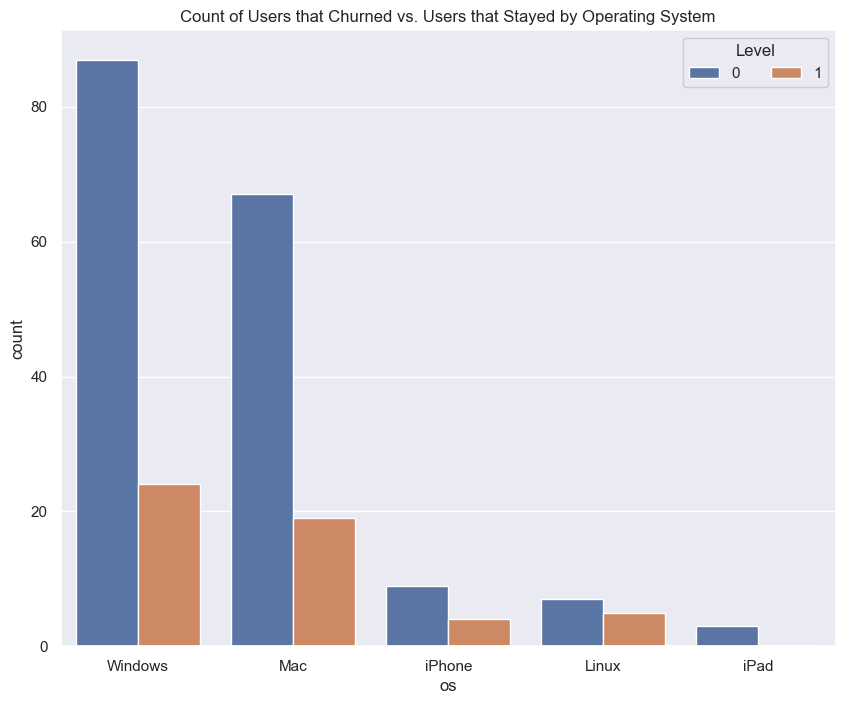

In [96]:
# Plot the count of users that churned vs. users that stayed by operating system
plt.figure(figsize=[10, 8])
sns.countplot(data=df_opsys, x='os', hue='churn', order=os_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Operating System')
plt.legend(loc=1, ncol=2, framealpha=1, title='Level')

Windows was the most used. Linux users have the highest rate of churn. It is very few customers that this has affected therefore this won't be used in our model.

We can also look if browsers had an effect on churn using the same process.

In [97]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [98]:
df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

In [99]:
df_opsys.browser.value_counts()

Chrome     117
Firefox     50
Safari      46
Trident     12
Name: browser, dtype: int64

Here Trident is Internet Explorer software. Let's change Trident to 'Internet Explorer' as it is better known.

In [100]:
df_opsys['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)

In [101]:
# order for the plot
browser_order = df_opsys.browser.value_counts().index

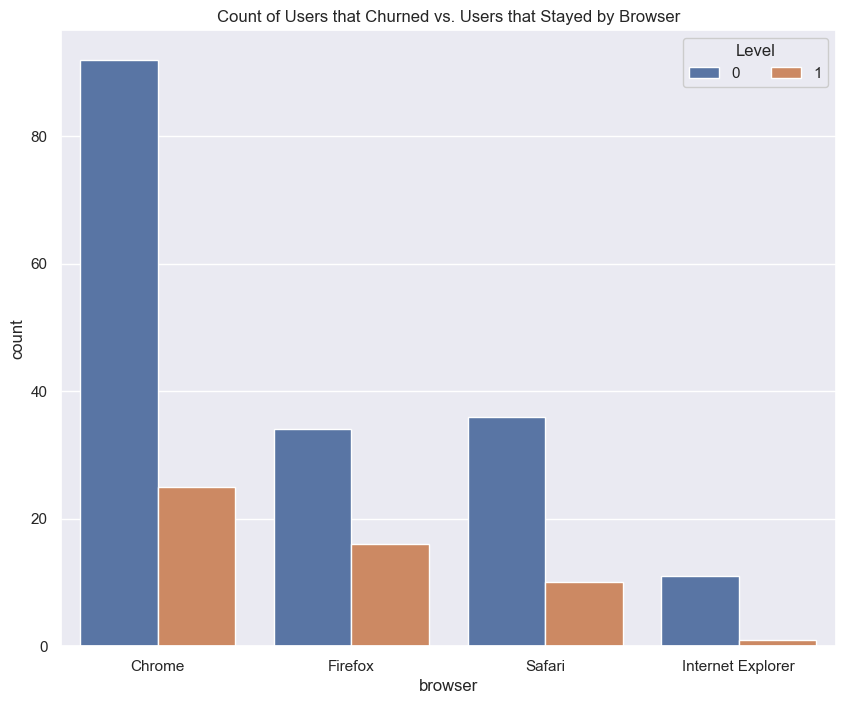

In [102]:
# Plot the count of users that churned vs. users that stayed by browser
plt.figure(figsize=[10, 8])
sns.countplot(data=df_opsys, x='browser', hue='churn', order=browser_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Browser')
plt.legend(loc=1, ncol=2, framealpha=1, title='Level')

Chrome was the most popular browser. Firefox users were most likely to churn. Internet Explorer had the fewest number of users that churned. There is no clear issue with browsers which is making users churn. Therefore this won't be used in our model.

### Days Since Registration for Sparkify

Finally, we can look at the number of days since a user had registered.

In [103]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [104]:
# order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [105]:
# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [106]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [107]:
# just get those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [108]:
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

Now need to minus these and work that out in days.

In [109]:
# need to minus the registration from ts 
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [110]:
df_days.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [111]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [112]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [113]:
# to Pandas for the plot
df_days_pd = df_days.toPandas()

In [114]:
df_days_pd

,userId,registration,ts,churn,delta_days,days
0,10,1538159495000,1542631788000,0,4472293000,51.762650
1,100,1537982255000,1543587349000,0,5605094000,64.873773
2,100001,1534627466000,1538498205000,1,3870739000,44.800220
3,100002,1529934689000,1543799476000,0,13864787000,160.472072
4,100003,1537309344000,1539274781000,1,1965437000,22.748113
...,...,...,...,...,...,...
220,95,1538211832000,1543591644000,0,5379812000,62.266343
221,96,1537149749000,1543537879000,0,6388130000,73.936690
222,97,1536019842000,1543570634000,0,7550792000,87.393426
223,98,1538069638000,1543548229000,0,5478591000,63.409618


Text(0, 0.5, 'Days Since Registered')

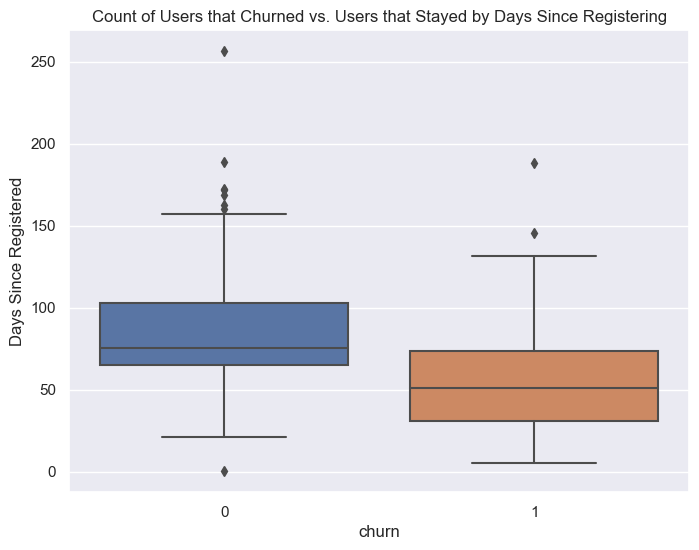

In [115]:
# Plot a boxplot for the count of users that churned vs. users that stayed by days since registering
plt.figure(figsize=[8, 6])
sns.boxplot(data=df_days_pd, x='churn', y='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered")


On average those who had been registered with Sparkify for longer were more likely to stay. Users who had registered more recently were more likely to churn.

# Feature Engineering
<a class="anchor" id="eng"></a>

Now that EDA has been performed, we can build out the features that seem most promising to train our model on.

The features we will build out are:

### Categorical:
- Gender
- Level (Paid or Free)

### Numerical:
- Number of Songs per Session
- Number of RollAds Actions
- Number of Thumb Down Actions
- Number of Thumbs Up Actions
- Number of Friends Added
- Number of Songs Added to Playlist
- Number of Different Artists Listened to on Sparkify
- Number of Days Since Registering

We will also then add a churn


First we will take our categorical variables and convert these into numeric variables, ready for our model.

### Gender

Our first feature is gender which is a categorical one. We will assign a 1 for 'female' and a 0 for 'male'.

In [116]:
# Create a DataFrame for gender interactions, removing duplicates based on userId
gender_f1 = df.select(['userId', 'gender']).dropDuplicates()

In [117]:
# create gender column 
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [118]:
gender_f1.count()

225

In [119]:
# check
gender_f1.show(20)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    39|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   100|     0|
|    25|     1|
|    92|     1|
|    52|     1|
|   110|     0|
|    33|     0|
|    42|     1|
|    67|     0|
|    77|     1|
|   136|     1|
|    99|     1|
|   114|     0|
+------+------+
only showing top 20 rows



### Level

The next feature we will take is level. The level can change so we need to only take the most recent. We can use the rank trick from before.

In [120]:
# Create a DataFrame with userId, level, and timestamp, removing duplicates and sorting by userId
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [121]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [122]:
df2 = df2.withColumn("Rank", dense_rank().over(w))

In [123]:
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [124]:
level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)

In [125]:
level_f2 = level_f2.drop('ts')

In [126]:
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [127]:
level_f2.count()

225

In [128]:
level_f2.show(20)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



### Average Number of songs per session

Our third feature is average number of songs per session for each user.

In [129]:
# Create a DataFrame for song interactions, grouped by userId and sessionId
song_f3 = df.filter(df.page == "NextSong").groupBy('userId', 'sessionId').count()

In [130]:
# Show the first two rows of the DataFrame for song interactions
df.filter(df.page == "NextSong").groupBy('userId', 'sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [131]:
song_f3 = song_f3.groupby('userId').agg({"count":"avg"})

In [132]:
song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")

In [133]:
song_f3.count()

225

In [134]:
song_f3.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



### Number of rollads actions


Next feature we can consider is number of roll advert actions. This had a higher number of roll ad count for those who churned since those who use the app for free are shown ads whereas paid subscribers aren't shown ads.

In [135]:
rollad_f4 = df.select(["userId", "page"])

In [136]:
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [137]:
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))

In [138]:
rollad_f4 = rollad_f4.groupby('userId').sum("rollad")

In [139]:
rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

In [140]:
rollad_f4.count()

225

In [141]:
rollad_f4.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|    51|      0|
|   124|      4|
+------+-------+
only showing top 2 rows



### Number of thumb down actions


The fifth feature we can add to our feature dataframe is thumbs down. Users who had churned in the past had performed more thumbs down actions than those who stayed with the service. 

In [142]:
thumbdown_f5 = df.select(["userId", "page"])

In [143]:
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [144]:
thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))

In [145]:
thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")

In [146]:
thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [147]:
thumbdown_f5.count()

225

In [148]:
thumbdown_f5.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|    51|         21|
|   124|         41|
+------+-----------+
only showing top 2 rows



### Number of thumbs up actions


We can do the same for thumb up actions. Users who stayed with the service had performed more thumbs up actions in the past.

In [149]:
thumbup_f6 = df.select(["userId", "page"])

In [150]:
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [151]:
thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))

In [152]:
thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")

In [153]:
thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [154]:
thumbup_f6.count()

225

In [155]:
thumbup_f6.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|    51|      100|
|   124|      171|
+------+---------+
only showing top 2 rows



### Number of friends added


Similarly, number of friends added can indicate if a user is likely to churn or not. In the past, those who added more friends stayed with the app.

In [156]:
friend_f7 = df.select(["userId", "page"])

In [157]:
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [158]:
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))

In [159]:
friend_f7 = friend_f7.groupby('userId').sum("add_friend")

In [160]:
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")

In [161]:
friend_f7.count()

225

In [162]:
friend_f7.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|    51|        28|
|   124|        74|
+------+----------+
only showing top 2 rows



### Number of songs added to playlist

Again, those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [163]:
playlist_f8 = df.select(["userId", "page"])

In [164]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [165]:
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))

In [166]:
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")

In [167]:
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")

In [168]:
playlist_f8.count()

225

In [169]:
playlist_f8.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|    51|      52|
|   124|     118|
+------+--------+
only showing top 2 rows



### Number of different Artists Listened to on Sparkify

As we discovered in EDA, users that listened to more diverse artists were less likely to churn.

In [170]:
artists_f9 = df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [171]:
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")

In [172]:
artists_f9.count()

225

In [173]:
artists_f9.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



### Number of Days Since Registering

Number of days since registering also looked useful from our EDA. We saw that users who had a shorter number of days since registering churned more than those who had used the service for a longer time.

In [174]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [175]:
days_f10 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

In [176]:
days_f10.count()

225

In [177]:
days_f10.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



### Label

Now we can create our label column indicating if the user churned (1) or not (0).

In [178]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [179]:
label = label.drop('count')

In [180]:
label.count()

225

In [181]:
label = label.withColumnRenamed("churn", "label")

In [182]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



### Create Features Dataset

Now that we have our features we need to join these together on `userId`.

In [183]:
feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])

In [184]:
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|    10|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|
|   100|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|
|100001|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|
|100002|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|
|100003|     1|    0|              25.5|      9|          0|        3|         0|       2|         51|22

Now we can drop the userId.

In [185]:
feature_df = feature_df.drop('userId')

In [186]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|
|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|
|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|
|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|
|     1|    0|              25.5|      9|          0|        3|         0|       2|         51|22.748113425925926|    1|
|     1|    1|              47.1

Now we have a dataframe with all the features we can into our model where each row represents a user.However first we need to do some preprocessing.

## Preprocessing

In [187]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



Now we need to take these columns and convert them into the numerical datatypes that will be used in our model: integers and floats. To adhere to DRY (Don't Repeat Yourself) principles, we can write a function for this purpose

In [188]:
# Loop through each column in feature_df
for feature in feature_df.columns:
    # Cast the column to float data type
    feature_df = feature_df.withColumn(feature, col(feature).cast('float'))

In [189]:
#check this works
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



The next stage of preprocessing is to vectorise our features.

### Vector Assembler

The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [190]:
# Create a VectorAssembler with specified input and output columns
assembler = VectorAssembler(
    inputCols=["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"],
    outputCol="vec_features"
)

In [191]:
feature_df = assembler.transform(feature_df)

In [192]:
feature_df.show()

+------+-----+----------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|gender|level|  avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|     days|label|        vec_features|
+------+-----+----------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|   0.0|  1.0|112.166664|    1.0|        4.0|     37.0|      12.0|     9.0|      566.0| 51.76265|  0.0|[0.0,1.0,112.1666...|
|   0.0|  1.0| 78.882355|   25.0|       27.0|    148.0|      49.0|    61.0|     1706.0| 64.87377|  0.0|[0.0,1.0,78.88235...|
|   1.0|  0.0|     33.25|   14.0|        2.0|      8.0|       2.0|     3.0|      126.0| 44.80022|  1.0|[1.0,0.0,33.25,14...|
|   1.0|  1.0|     48.75|    3.0|        0.0|      5.0|       1.0|     5.0|      185.0|160.47208|  0.0|[1.0,1.0,48.75,3....|
|   1.0|  0.0|      25.5|    9.0|        0.0|      3.0|       0.0|     2.0|       51.0|22.748114|  1.0|[1.0,0.0,25.5,9.0...|


### Standardisation

Now that we have our vectors we can standardise our values. This is important for our machine learning model so that those features with the highest values don't dominate the results and so that we can make the individual features look like standard normally distributed data.

In [193]:
# Create a StandardScaler with specified input and output columns
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [194]:
scaler_model = scaler.fit(feature_df)

In [195]:
feature_df = scaler_model.transform(feature_df)

In [196]:
feature_df.head(2)

[Row(gender=0.0, level=1.0, avg_song=112.16666412353516, roll_ad=1.0, thumbs_down=4.0, thumbs_up=37.0, add_friend=12.0, playlist=9.0, num_artists=566.0, days=51.76264953613281, label=0.0, vec_features=DenseVector([0.0, 1.0, 112.1667, 1.0, 4.0, 37.0, 12.0, 9.0, 566.0, 51.7626]), features=DenseVector([0.0, 2.0844, 2.6321, 0.0464, 0.3059, 0.5651, 0.583, 0.2751, 0.9372, 1.3744])),
 Row(gender=0.0, level=1.0, avg_song=78.88235473632812, roll_ad=25.0, thumbs_down=27.0, thumbs_up=148.0, add_friend=49.0, playlist=61.0, num_artists=1706.0, days=64.87377166748047, label=0.0, vec_features=DenseVector([0.0, 1.0, 78.8824, 25.0, 27.0, 148.0, 49.0, 61.0, 1706.0, 64.8738]), features=DenseVector([0.0, 2.0844, 1.851, 1.1601, 2.0646, 2.2603, 2.3808, 1.8645, 2.8247, 1.7226]))]

We can observe that standardization has been successfully applied:

- Original `vec_features`: `[0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]`
- Scaled `features`: `[0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]`


## Train / Test / Validation Split

Let's check how many records we have in total is 225 as it should be.

In [197]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



This count is what we would expect, now we can split our data into train, test and validation sets. Here we will do a 60:20:20 split and include a seed so we can reproduce the result. I've included the same seed for the different machine learning models so that my results can be reproduced.

In [198]:
# Split the dataset into training, testing, and validation sets
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed=1996)

# Print the counts for each dataset
print("Training Dataset:", train.count())
print("Test Dataset:", test.count())
print("Validation Dataset:", valid.count())

Training Dataset: 133


Test Dataset: 42


Validation Dataset: 50


# Modelling

Now that we have created our features DataFrame with only numeric variables, we can split the full dataset into train, test, and validation sets. We will test out different machine learning classification algorithms including:

- Logistic Regression
- Random Forest Classifier
- Gradient-Boosted Tree Classifier
- Linear Support Vector Machine
- Naive Bayes

We will use these classification algorithms since churn prediction is a binary classification problem, meaning that customers will either churn (1) or they will stay (0) in a certain period of time.

### Metrics

We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I will use F1 score as the metric to optimize. 

F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here.


Now we can start modelling. When we identify the model with the best F1 score, accuracy and time we will then tune the model.

### Training the Models & Evaluating the Model Performance
Steps:
 - Instantiate 
 - Fit Models on Train
 - Predicting
 - Evaluating


In [199]:
# Model Instantiation

# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=1996)

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=10, seed=1996)

# Linear Support Vector Machine
lsvc = LinearSVC(featuresCol='features', labelCol='label')

# Naive Bayes
nb = NaiveBayes(featuresCol='features', labelCol='label')

In [200]:
# List of Models
model_list = [lr, rf, gbt, lsvc, nb]

In [201]:
# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [202]:
# Model Training and Evaluation Loop
for model in model_list:
    model_name = model.__class__.__name__
    
    print(model_name, 'training started')
    
    start = time.time()
    model = model.fit(train)
    end = time.time()
    
    print(model_name, 'training ended')
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started


23/09/22 21:11:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


LogisticRegression training ended
Time taken for LogisticRegression is: 35.766321897506714 seconds
LogisticRegression predicting started
LogisticRegression predicting ended


F1 for LogisticRegression is: 0.8075


The accuracy of the LogisticRegression model is: 0.8
RandomForestClassifier training started


RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 41.3046190738678 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended


F1 for RandomForestClassifier is: 0.8319047619047617


The accuracy of the RandomForestClassifier model is: 0.84
GBTClassifier training started


GBTClassifier training ended
Time taken for GBTClassifier is: 18.934036016464233 seconds
GBTClassifier predicting started
GBTClassifier predicting ended


F1 for GBTClassifier is: 0.8075


The accuracy of the GBTClassifier model is: 0.8
LinearSVC training started


LinearSVC training ended
Time taken for LinearSVC is: 42.326855182647705 seconds
LinearSVC predicting started
LinearSVC predicting ended


F1 for LinearSVC is: 0.8294394213381556


The accuracy of the LinearSVC model is: 0.82
NaiveBayes training started


NaiveBayes training ended
Time taken for NaiveBayes is: 16.405883073806763 seconds
NaiveBayes predicting started
NaiveBayes predicting ended


F1 for NaiveBayes is: 0.7186516853932585


The accuracy of the NaiveBayes model is: 0.78


Now that we have our results we can choose our best model. Random Forest and Gradient Boosted Trees performed well but random forest was faster so I will choose this one to tune. 

## Model Tuning for Best Models:

### Random Forest

### Best Model Performance Results:

## Parameters

For tuning our Random Forest model, I focused on `numTrees` and `maxDepth`:

- **NumTrees**: I explored values from 20, 50, to 100 to strike a balance between performance and avoiding overfitting. Ensembles like Random Forest benefit from more trees, up to a point.

- **MaxDepth**: I limited the depth to 5, 10, and 15 to control the complexity of individual trees and mitigate overfitting. A deeper tree can potentially capture more complex relationships but may lead to overfitting.

- **NumFolds**: Initially set to 5 for robust cross-validation, I adjusted it to 3 to expedite the process. This is a trade-off between thorough evaluation and computational efficiency.

In [205]:
# Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()

# Cross-Validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [206]:
%%time
cvModel = crossval.fit(train)

CPU times: user 6.68 s, sys: 3.21 s, total: 9.88 s
Wall time: 8min 39s


In [207]:
cvModel.avgMetrics

[0.7917010619114406,
 0.7813463409933394,
 0.7813463409933394,
 0.7962844654770119,
 0.783049171359365,
 0.783049171359365,
 0.7849097018448408,
 0.7849097018448408,
 0.7849097018448408]

We can now get the final results for our random forest model.

In [208]:
results = cvModel.transform(valid)

In [209]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [210]:
best_model = cvModel.bestModel

In [211]:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  50
Best Param (MaxDepth):  5


In [212]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.7186516853932585


In [213]:
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.78


## Model Evaluation

After training and fine-tuning our Random Forest model using cross-validation, we achieved an F1 score of 0.78 and an accuracy of 78%.

The accuracy measures the proportion of correctly predicted data points out of all predictions made. In this case, we have 78 correct predictions out of 100 total predictions.

To get a more detailed understanding of the model's performance, we can use a confusion matrix:


#### Feature Importance:

Finally, we can check the feature importance for our best model and plot this in a chart.

In [214]:
importances = best_model.featureImportances

In [215]:
x_values = list(range(len(importances)))

In [216]:
feature_list = list(["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"])

Text(0.5, 1.0, 'Feature Importances')

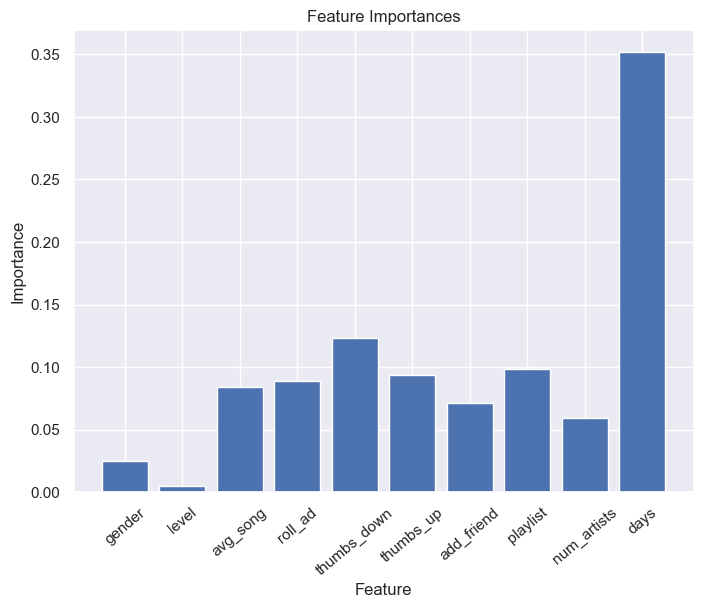

In [217]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

Here we can see that the feature with the highest importance was days since registered. Gender and level were the least important features.

# Conclusion

Throughout this project, we undertook a detailed analysis of Sparkify's user interactions with the aim of predicting customer churn. The dataset, though small in size, provided valuable insights into user behavior. After thorough data cleaning and feature engineering, we constructed a set of features including user demographics, activity metrics, and engagement patterns.

Utilizing machine learning models, we evaluated various classifiers including Logistic Regression, Random Forest, Gradient-Boosted Tree, Linear Support Vector Machine, and Naive Bayes. Among these, the Random Forest Classifier stood out as the best performer, achieving an accuracy of 0.78 on the validation set. This model was further fine-tuned using hyperparameter optimization to ensure optimal performance.

### Business Impact

The application of this predictive model holds significant business value for Sparkify. Armed with the ability to identify potential churners, the company can proactively engage with these customers, offering tailored incentives or personalized experiences to encourage retention. By focusing on newer customers, Sparkify may particularly mitigate the risk of early churn.

### Project Reflection

This project not only honed my skills in data preprocessing and machine learning modeling with PySpark but also deepened my understanding of churn prediction in a real-world context. The Random Forest algorithm emerged as the most effective in this scenario, showcasing its power in handling imbalanced classes.

### Future Work

For future enhancements, it would be beneficial to conduct more comprehensive feature engineering, giving priority to those features that exhibit the highest predictive power. Additionally, addressing potential overfitting concerns and conducting a thorough analysis of misclassified instances could further refine the model's performance.
